In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import datetime
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from sklearn import metrics
from sklearn.utils import shuffle
from skimage import draw
from skimage.io import imread,imsave
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from skimage.util import pad
import skimage
import time
import math

from tqdm import tqdm_notebook as tqdm 

from Dataset.DistanceMapDataset import DataSet,Scale,ToTensor,RandomGaussionBlur,RandomMedianBlur\
,RandomHorizontalFlip,RandomRotation,visualize_loader

import warnings
warnings.filterwarnings('ignore')

from Models import DualEncoding_U_Net, save_model,load_model,init_weights,DualEncodingDecoding_U_Net
from Metrics import SoftDiceLoss,dice_metric,MultiClassBCE,SoftDiceLoss,HV_Loss
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
if not os.path.exists('processed_data'):
    os.mkdir('processed_data')
    
import pickle



The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [5]:
!ls other_data/CPM_17/Test/horizontal_maps/gbm_image01.png 

gbm_image01.png  hnsc_image01.png  lgg_image01.png  lung_image01.png
gbm_image02.png  hnsc_image02.png  lgg_image02.png  lung_image02.png
gbm_image03.png  hnsc_image03.png  lgg_image03.png  lung_image03.png
gbm_image04.png  hnsc_image04.png  lgg_image04.png  lung_image04.png
gbm_image05.png  hnsc_image05.png  lgg_image05.png  lung_image05.png
gbm_image06.png  hnsc_image06.png  lgg_image06.png  lung_image06.png
gbm_image07.png  hnsc_image07.png  lgg_image07.png  lung_image07.png
gbm_image08.png  hnsc_image08.png  lgg_image08.png  lung_image08.png


In [2]:

h_e_train_patch_dir='other_data/CPM_17/{}/H_E_patches'.format('Train')
h_train_patch_dir='other_data/CPM_17/{}/H_patches'.format('Train')

nuclei_mask_train_patch_dir='other_data/CPM_17/{}/nuclei_patches'.format('Train')
boundary_mask_train_patch_dir='other_data/CPM_17/{}/boundary_patches'.format('Train')
hor_train_patch_dir='other_data/CPM_17/{}/horizontal_patches'.format('Train')
ver_train_patch_dir='other_data/CPM_17/{}/vertical_patches'.format('Train')

h_e_test_patch_dir='other_data/CPM_17/{}/H_E_patches'.format('Test')
h_test_patch_dir='other_data/CPM_17/{}/H_patches'.format('Test')

nuclei_mask_test_patch_dir='other_data/CPM_17/{}/nuclei_patches'.format('Test')
boundary_mask_test_patch_dir='other_data/CPM_17/{}/boundary_patches'.format('Test')
hor_test_patch_dir='other_data/CPM_17/{}/horizontal_patches'.format('Test')
ver_test_patch_dir='other_data/CPM_17/{}/vertical_patches'.format('Test')


95
85
MAX VALUE :  
H&E 1.0 
H 1.0 
nuclei_mask 1.0 
hor_map 1.0 
ver_map 1.0


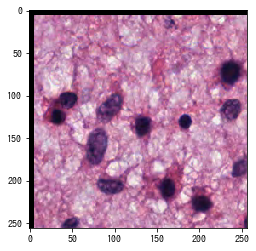

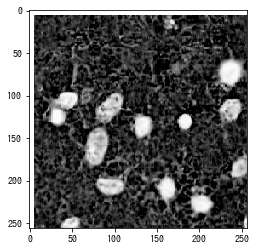

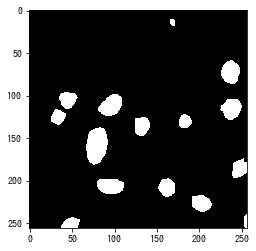

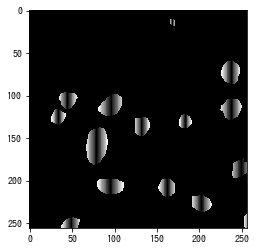

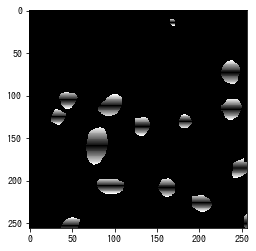

In [3]:
batch_size_train=4
batch_size_test=4
                                                
train_transform=torchvision.transforms.Compose([RandomGaussionBlur(p=0.4,sigma=0.5,truncate=4,apply_dual=False),\
                                                RandomMedianBlur(p=0.4,disk_rad=1),\
                                                RandomHorizontalFlip(p=0.4),\
                                                RandomRotation( degrees=[60,120],p=0.38),\
                                                Scale(),\
                                                ToTensor()])
test_transform=torchvision.transforms.Compose([Scale(),ToTensor()])
train_dataset=DataSet(h_e_train_patch_dir,h_train_patch_dir\
                      ,nuclei_mask_train_patch_dir, hor_train_patch_dir,ver_train_patch_dir\
                      ,transform=train_transform,attn_gray=True)
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_dataset=DataSet(h_e_test_patch_dir,h_test_patch_dir\
                      ,nuclei_mask_test_patch_dir, hor_test_patch_dir,ver_test_patch_dir\
                      ,transform=test_transform,attn_gray=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=False)

print(train_loader.__len__())
print(test_loader.__len__())
visualize_loader(test_loader,0)

In [19]:
# model=DualEncoding_U_Net(img1_ch=3,img2_ch=1,output_ch=2,dropout=0.4,include_ffm=False)
model=DualEncodingDecoding_U_Net(img_ch1=3,img_ch2=1,output_ch1=1,output_ch2=2,dropout=0.45)
# model=AttnUNet(img_ch=2,output_ch=1,dropout=0.5)
model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'model_CPM_17_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('{} dir has been made'.format(BEST_MODEL_PATH))
print("Model's state_dict:")
writer = SummaryWriter('{}/experiment_{}'.format(BEST_MODEL_PATH,1))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/datalab/training-assets/R_medical/atheeth/nuclei_seg/model_CPM_17_2020_02_18 dir has been made
Model's state_dict:
Conv1_encoding_1.conv.0.weight 	 torch.Size([64, 3, 3, 3])
Conv1_encoding_1.conv.0.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.weight 	 torch.Size([64])
Conv1_encoding_1.conv.1.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.1.num_batches_tracked 	 torch.Size([])
Conv1_encoding_1.conv.3.weight 	 torch.Size([64, 64, 3, 3])
Conv1_encoding_1.conv.3.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.weight 	 torch.Size([64])
Conv1_encoding_1.conv.4.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.4.num_batches_tracked 	 torch.Size([])
Conv2_encoding_1.conv.0.weight 	 torch.Size([128, 64, 3, 3])
Conv2_encoding_1.conv.0.bias 	 torch.Size([128])
Conv2_encoding_1.co

Up_conv5_decod_1.0.weight 	 torch.Size([512, 1024, 1, 1])
Up_conv5_decod_1.0.bias 	 torch.Size([512])
Up_conv5_decod_1.1.weight 	 torch.Size([512])
Up_conv5_decod_1.1.bias 	 torch.Size([512])
Up_conv5_decod_1.1.running_mean 	 torch.Size([512])
Up_conv5_decod_1.1.running_var 	 torch.Size([512])
Up_conv5_decod_1.1.num_batches_tracked 	 torch.Size([])
Up_sample4_decod_1.up.1.weight 	 torch.Size([256, 512, 3, 3])
Up_sample4_decod_1.up.1.bias 	 torch.Size([256])
Up_sample4_decod_1.up.2.weight 	 torch.Size([256])
Up_sample4_decod_1.up.2.bias 	 torch.Size([256])
Up_sample4_decod_1.up.2.running_mean 	 torch.Size([256])
Up_sample4_decod_1.up.2.running_var 	 torch.Size([256])
Up_sample4_decod_1.up.2.num_batches_tracked 	 torch.Size([])
Up_conv4_decod_1.0.weight 	 torch.Size([256, 512, 1, 1])
Up_conv4_decod_1.0.bias 	 torch.Size([256])
Up_conv4_decod_1.1.weight 	 torch.Size([256])
Up_conv4_decod_1.1.bias 	 torch.Size([256])
Up_conv4_decod_1.1.running_mean 	 torch.Size([256])
Up_conv4_decod_1.1.ru

In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
pretrained=False
optimizer_selected='adam'
scheduler_type='reduce_on_plateau'
batchsize=batch_size_train
no_steps=train_dataset.__len__()//batchsize
restart_epochs=8
num_epochs=100
predict_hover=True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#criterion = SoftDiceLoss()#
criterion=HV_Loss()
# criterion=MultiClassBCE(weights=[0.65,0.35])
# criterion=DE_loss()

history={'train_loss':[],'test_loss':[],'train_dice':[],'test_dice':[]}
model = model.to(device)

if optimizer_selected=='adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-03, betas=(0.9, 0.98),weight_decay=0.02)
else:
    optimizer = torch.optim.SGD(model.parameters(),lr=1e-03, momentum=0.8,nesterov=True)


if scheduler_type=='reduce_on_plateau':
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6,\
                                               verbose=True, threshold=0.0001, threshold_mode='rel',\
                                               cooldown=2, min_lr=10e-06, eps=1e-08)
    
else:
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
                                                     eta_min=1e-012, last_epoch=-1)

if pretrained:
    filename='model_CPM_17_v2_2020_02_07/model_optim.pth'
    load_model(filename,model,optimizer=None,scheduler=None)
else:
    init_weights(model)

best_val=0
for epoch in range(num_epochs):
    
    print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
    # loop over the dataset multiple times
    
    run_avg_train_loss=0
    run_avg_train_dice=0
    
   
    
    run_avg_test_loss=0
    run_avg_test_dice=0
    
    for mode in ['train','eval']:
     
        if mode == 'train':
            
            model.train()
            loop=tqdm(train_loader)
            
            for i, sample_batched in (enumerate(loop)):
                loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                
                #Clear Gradients
                optimizer.zero_grad()
                
                # get the inputs; data is a list of [dapi, nuclei, boundary]
                if predict_hover:
                    h_e_train, h_train,nuclei_mask_train,hor_map_train,ver_map_train = sample_batched['h_e']\
                    ,sample_batched['h']\
                    ,sample_batched['nuclei_mask']\
                    ,sample_batched['hor_map']\
                    ,sample_batched['ver_map']
                    
                    h_e_train, h_train,nuclei_mask_train,hor_map_train,ver_map_train = \
                    h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                    ,nuclei_mask_train.to(device, dtype = torch.float)\
                    ,hor_map_train.to(device, dtype = torch.float),ver_map_train.to(device, dtype = torch.float)
                    
                    gt_mask_train=torch.cat((nuclei_mask_train,hor_map_train,ver_map_train),dim=1)
                    
                    
                
                else:
                    h_e_train, h_train,nuclei_mask_train= sample_batched['h_e']\
                    ,sample_batched['h']\
                    ,sample_batched['nuclei_mask']\

                    h_e_train, h_train,nuclei_mask_train= \
                    h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                    ,nuclei_mask_train.to(device, dtype = torch.float)
                    
                    gt_mask_train=nuclei_mask_train

                # forward + backward + optimize
#                 img_batch_comb=torch.cat((img_batch,dapi_batch),dim=1)
                outputs,attn_maps_train= model(h_e_train,h_train)
                outputs=torch.sigmoid(outputs)
                
    
                if predict_hover:
                    pred_nuclei_train,pred_hor_train,pred_ver_train=torch.chunk(outputs,3,dim=1)
                else:
                    pred_nuclei_train=outputs
                

                
                loss = criterion(outputs, gt_mask_train)
                dice_score=dice_metric(pred_nuclei_train,nuclei_mask_train)
                run_avg_train_loss=(run_avg_train_loss*(0.9))+loss.detach().item()*0.1
                run_avg_train_dice=(run_avg_train_dice*(0.9))+dice_score.detach().item()*0.1
               
                if (i+1)%50==0:
                    
                    if predict_hover:
                        img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu(),\
                                             pred_hor_train.detach().cpu(),hor_map_train.detach().cpu(),\
                                             pred_ver_train.detach().cpu(),ver_map_train.detach().cpu()),dim=0)
                    else:
                        img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu()),dim=0)
                        
                    img_grid2 = torchvision.utils.make_grid(img_tensor,nrow=batch_size_train,padding=10)
                    torchvision.utils.save_image\
                    (img_grid2,os.path.join(BEST_MODEL_PATH,\
                                            'train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
                        
                    attn_index=np.random.randint(0,4)
                    torchvision.utils.save_image\
                    (attn_maps_train[attn_index][0][0],os.path.join(BEST_MODEL_PATH,\
                                            'attnMap{}_train_iter_{}.png'.format(attn_index,epoch*len(train_loader)+i+1)))
                    
                    
                    
#                     writer.add_image('TRAIN_ITER_{}'.format(epoch * len(train_loader) + i+1), img_grid2)
                    
                    
                    writer.add_scalar('Training dice score nuclei',
                            run_avg_train_dice,
                            epoch * len(train_loader) + i+1)
                
                    writer.add_scalar('Training Loss',
                            run_avg_train_loss,
                            epoch * len(train_loader) + i+1)
                    
                loss.backward()
                optimizer.step()
                
                if scheduler_type!='reduce_on_plateau':
                    scheduler.step()
                
                
                loop.set_postfix(loss=run_avg_train_loss,dice_score=run_avg_train_dice)
                
               
            history['train_loss'].append(run_avg_train_loss)
            history['train_dice'].append(run_avg_train_dice)
            
            writer.add_scalar('Train dice { epoch }',
                            run_avg_train_dice,
                            epoch+1)
                
            writer.add_scalar('Train loss { epoch }',
                    run_avg_train_loss,
                    epoch * len(train_loader) + i+1)
                
                 
                    
        elif mode =='eval':
            #Clear Gradients
            optimizer.zero_grad()
            samples_test=len(test_loader)
            model.eval()
            val_loss=0
            test_agg=0
            for j, test_sample in enumerate(test_loader):
                
                
                if predict_hover:
                    h_e_test, h_test,nuclei_mask_test,hor_map_test,ver_map_test = test_sample['h_e']\
                    ,test_sample['h']\
                    ,test_sample['nuclei_mask']\
                    ,test_sample['hor_map']\
                    ,test_sample['ver_map']
                    
                    h_e_test, h_test,nuclei_mask_test,hor_map_test,ver_map_test = \
                    h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
                    ,nuclei_mask_test.to(device, dtype = torch.float)\
                    ,hor_map_test.to(device, dtype = torch.float)\
                    ,ver_map_test.to(device, dtype = torch.float)
                    
                    gt_mask_test=torch.cat((nuclei_mask_test,hor_map_test,ver_map_test),dim=1)
                    
                else:
                
                    h_e_test, h_test,nuclei_mask_test= test_sample['h_e']\
                    ,test_sample['h']\
                    ,test_sample['nuclei_mask']

                    h_e_test, h_test,nuclei_mask_test = \
                    h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
                    ,nuclei_mask_test.to(device, dtype = torch.float)

                    gt_mask_test=nuclei_mask_test
    
                test_outputs,attn_maps_test = model(h_e_test,h_test)
                test_outputs=torch.sigmoid(test_outputs)
        
        
                if predict_hover:
                    pred_nuclei_test,pred_hor_test,pred_ver_test=torch.chunk(test_outputs,3,dim=1)
                else:
                    pred_nuclei_test=test_outputs
    
                test_loss = criterion(test_outputs, gt_mask_test)
                test_dice=dice_metric(pred_nuclei_test,nuclei_mask_test)
                
                run_avg_test_loss=(run_avg_test_loss*(0.9))+test_loss.detach().item()*0.1
                run_avg_test_dice=(run_avg_test_dice*(0.9))+test_dice.detach().item()*0.1
                
               
                if (j+1)%50==0:
                    if predict_hover:
                        img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu(),\
                                                  pred_hor_test.detach().cpu(),hor_map_test.detach().cpu(),\
                                                  pred_ver_test.detach().cpu(),ver_map_test.detach().cpu()),dim=0)
                    else:
                        img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu()),dim=0)
                    
                    
                    
                    img_grid = torchvision.utils.make_grid(img_tensor_test,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image\
                    (img_grid,os.path.join(BEST_MODEL_PATH,\
                                            'test_iter_{}.png'.format(epoch*len(test_loader)+j+1)))
                    attn_index=np.random.randint(0,4)
                   
                    torchvision.utils.save_image\
                    (attn_maps_test[attn_index][0][0],os.path.join(BEST_MODEL_PATH,\
                                            'attnMap{}_test_iter_{}.png'.format(attn_index,epoch*len(test_loader)+j+1)))
                    
#                     writer.add_image('TEST_ITER_{}'.format(epoch * len(test_loader) + j+1), img_grid)
                    writer.add_scalar('Testing dice score ',\
                                      run_avg_test_dice,epoch * len(test_loader) + j+1)
                    
                    writer.add_scalar('Testing Loss',\
                                      run_avg_test_loss,epoch * len(test_loader) + j+1)
                
            print("test_loss: {}\ntest_dice :{}"\
                  .format(run_avg_test_loss,run_avg_test_dice))
            history['test_loss'].append(run_avg_test_loss)
            history['test_dice'].append(run_avg_test_dice)
            
            writer.add_scalar('Test dice { epoch }',
                            run_avg_test_dice,
                            epoch+1)
                
            writer.add_scalar('Test loss { epoch }',
                    run_avg_test_loss,
                    epoch * len(train_loader) + i+1)
            
            if run_avg_test_dice>best_val:
                best_val=run_avg_test_dice
                save_model(model,optimizer,BEST_MODEL_PATH+\
                           '/model_optim.pth',scheduler=scheduler)
                print("saved model with test dice score: {}".format(best_val))
            if scheduler_type=='reduce_on_plateau':
                scheduler.step(run_avg_test_loss)
    
#             print("val_loss {}".format(val_loss/samples_test))
save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler)    

with open("{}/history.txt".format(BEST_MODEL_PATH), "wb") as fp:   #Pickling
    pickle.dump(history, fp)
    
    
    

In [39]:
file_name='model_CPM_17_2020_02_14/model_optim.pth'
load_model(file_name,model,optimizer=None,scheduler=None)
model=model.to("cuda:0" if torch.cuda.is_available() else "cpu")
devide=("cuda:0" if torch.cuda.is_available() else "cpu")

Done loading


In [41]:
for i,sample_batched in enumerate(test_loader):
    if i==0:
        h_e_train, h_train,nuclei_mask_train,hor_map_train,ver_map_train = sample_batched['h_e']\
                            ,sample_batched['h']\
                            ,sample_batched['nuclei_mask']\
                            ,sample_batched['hor_map']\
                            ,sample_batched['ver_map']
        h_e_train, h_train,nuclei_mask_train,hor_map_train,ver_map_train = \
                    h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                    ,nuclei_mask_train.to(device, dtype = torch.float)\
                    ,hor_map_train.to(device, dtype = torch.float),ver_map_train.to(device, dtype = torch.float)
                    
        break

In [47]:
outputs,attn_maps_train= model(h_e_train,h_train)
print(outputs.size())

torch.Size([4, 3, 256, 256])


(256, 256)


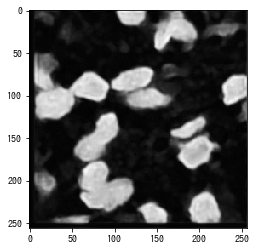

(256, 256)


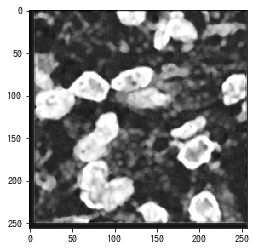

In [55]:
nuclei,hor,ver=torch.chunk(outputs,3,dim=1)
nuclei_np=nuclei[0].detach().cpu()
nuclei_np=nuclei_np.numpy().transpose((2,1,0))
nuclei_np=np.squeeze(nuclei_np)
print(nuclei_np.shape)
plt.imshow(nuclei_np,cmap='gray');plt.show()
hor_np=hor[0].detach().cpu()
hor_np=hor_np.numpy().transpose((2,1,0))
hor_np=np.squeeze(hor_np)
print(hor_np.shape)
plt.imshow(hor_np,cmap='gray');plt.show()

In [ ]:
# save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler) 

In [ ]:
# os.system("rm -rf {}".format(BEST_MODEL_PATH))